In [ ]:
!pip install interpret
!pip install scikit-learn
!pip install matplotlib
!pip install utils


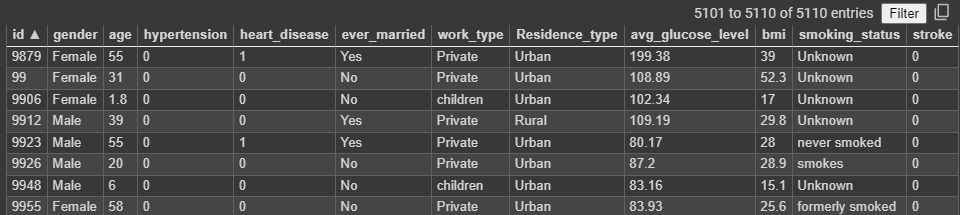


In [39]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

###This class help us handle the dataset for loading
####loading data + process data (select the item for testing, select attribute for evaluating)
####spliting data for train/test/validating
###oversampling techniques for ỉmprove the quality of data set
class DataLoader:
    def __init__(self):
        self.data = None
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None
        self.scaler = StandardScaler()
        self.smote = SMOTE(random_state=2021)
        self.feature_names = []  # To store feature names after preprocessing

    def load_dataset(self, file_path='/content/healthcare-dataset-stroke-data.csv'):
        """
        Load the dataset from a CSV file or another source.
        """
        self.data = pd.read_csv(file_path)

    def preprocess_data(self):
        """
        Preprocess the dataset: handle missing values, convert categorical variables, etc.
        """
        # Handle missing values, if necessary
        self.data.dropna(inplace=True)

        # Convert categorical features to numerical
        self.data = pd.get_dummies(self.data, drop_first=True)

        # Separate features and target variable
        self.X = self.data.drop(["id", "stroke"], axis=1)  # Assuming 'stroke' is the target variable
        self.y = self.data["stroke"]

        # Save the feature names after one-hot encoding
        self.feature_names = self.X.columns.tolist()

        # Feature scaling
        self.X = self.scaler.fit_transform(self.X)

    def get_data_split(self, test_size=0.2, random_state=2021):
        """
        Split the dataset into training and testing sets.
        """
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            self.X, self.y, test_size=test_size, random_state=random_state
        )
        return self.X_train, self.X_test, self.y_train, self.y_test

    def oversample(self, X, y):
        """
        Apply SMOTE to handle class imbalance in the training data.
        """
        X_resampled, y_resampled = self.smote.fit_resample(X, y)
        return X_resampled, y_resampled

# Initialize and use DataLoader
data_loader = DataLoader()
data_loader.load_dataset('/content/healthcare-dataset-stroke-data.csv')
data_loader.preprocess_data()
X_train, X_test, y_train, y_test = data_loader.get_data_split()
X_train, y_train = data_loader.oversample(X_train, y_train)


In [31]:
from interpret.glassbox import (LogisticRegression,
                                ClassificationTree,
                                ExplainableBoostingClassifier)
from interpret import show
from sklearn.metrics import f1_score, accuracy_score
import numpy as np

# %% Load and preprocess data with the above created class
data_loader = DataLoader()
data_loader.load_dataset()
data_loader.preprocess_data()

# Split the data for evaluation first
X_train, X_test, y_train, y_test = data_loader.get_data_split()
print("Training data shape:", X_train.shape)
print("Test data shape:", X_test.shape)

# Oversample the training data -> improve dataset
X_train, y_train = data_loader.oversample(X_train, y_train)
print("After oversampling:", X_train.shape)

# %% Fit logistic regression model
lr = LogisticRegression(
    random_state=2021,
    feature_names=data_loader.feature_names,  # Use actual feature names
    penalty='l1',
    solver='liblinear'
)

# Convert training data to numpy array if necessary
X_train = np.asarray(X_train, dtype=float)
y_train = np.asarray(y_train, dtype=float)  # Ensure y_train is also a numpy array

# Fit the logistic regression model
lr.fit(X_train, y_train)
print("Training finished.")

# %% Evaluate logistic regression model
y_pred = [int(float(pred)) for pred in y_pred]

# Ensure y_test and y_pred are of the same type and check their unique values
print(f"Unique values in y_test: {set(y_test)}")
print(f"Unique values in y_pred: {set(y_pred)}")

# Evaluate the model
print(f"Logistic Regression F1 Score: {f1_score(y_test, y_pred, average='macro')}")
print(f"Logistic Regression Accuracy: {accuracy_score(y_test, y_pred)}")

# %% Test local explanation
#num_samples = min(10, len(X_test))  # Adjust based on X_test size

num_samples = 20 # Adjust based on X_test size
# Convert test data to numpy array if necessary
X_test = np.asarray(X_test, dtype=float)
y_test = np.asarray(y_test, dtype=float)  # Ensure y_test is also a numpy array

try:
    lr_local = lr.explain_local(X_test[:num_samples], y_test[:num_samples], name='Logistic Regression')
    show(lr_local)
except IndexError as e:
    print("Visualization index error suppressed:", e)
except Exception as e:
    print("Error:", e)



Training data shape: (3927, 16)
Test data shape: (982, 16)
After oversampling: (7512, 16)
Training finished.
Unique values in y_test: {0, 1}
Unique values in y_pred: {0, 1}
Logistic Regression F1 Score: 0.535055527476062
Logistic Regression Accuracy: 0.7586558044806517


Coefficient Interpretation
Positive Coefficient:

Meaning: A positive coefficient for a feature indicates that as the value of that feature increases, the log odds of the positive class (or the probability of the positive class) also increases.
Impact: This means that higher values of this feature are associated with a higher likelihood of the target variable being the positive class (e.g., having a stroke).
Example: If a feature like avg_glucose_level has a positive coefficient, it suggests that higher glucose levels are associated with an increased probability of having a stroke.
Negative Coefficient:

Meaning: A negative coefficient indicates that as the value of that feature increases, the log odds of the positive class decreases.
Impact: This means that higher values of this feature are associated with a lower likelihood of the target variable being the positive class.
Example: If bmi has a negative coefficient, it implies that higher BMI values are associated with a decreased probability of having a stroke (assuming the feature has been properly scaled and interpreted).
Magnitude of the Coefficient

+ Larger Positive Coefficient: A larger positive coefficient means a stronger positive relationship between the feature and the probability of the positive class. This feature has a more significant effect on increasing the probability.
Larger Negative Coefficient:
+ A larger negative coefficient means a stronger negative relationship. This feature has a more significant effect on decreasing the probability.

In a logistic regression model, the intercept (also known as the bias term) is a crucial component. Here's a brief overview of what it means:

Intercept in Logistic Regression
Definition: The intercept is a constant term added to the linear combination of the features in the logistic regression model. In the model equation, it's the term that allows the decision boundary to shift vertically. It is represented as β₀ in the equation:

logit
(
𝑝
)
=
log
⁡
(
𝑝
1
−
𝑝
)
=
𝛽
0
+
𝛽
1
𝑥
1
+
𝛽
2
𝑥
2
+
…
+
𝛽
𝑛
𝑥
𝑛
logit(p)=log(
1−p
p
​
 )=β
0
​
 +β
1
​
 x
1
​
 +β
2
​
 x
2
​
 +…+β
n
​
 x
n
​

where
𝑝
p is the probability of the positive class,
𝑥
𝑖
x
i
​
  are the feature values, and
𝛽
𝑖
β
i
​
  are the coefficients for each feature.

Role:

Shifting the Decision Boundary: The intercept allows the model to fit the data more flexibly by shifting the decision boundary. Without an intercept, the decision boundary would always pass through the origin, which could limit the model’s ability to capture the relationships in the data.

Adjusting for Bias: It accounts for the fact that the features alone might not always perfectly explain the response variable, and it adjusts the predictions to better fit the data.

Example:** If the intercept is positive, it means that even when all feature values are zero, the model's predicted probability of the positive class is higher**. Conversely, if the intercept is negative, it suggests that the model predicts a lower probability of the positive class in the absence of features.

Interpretation
The value of the intercept in logistic regression can provide insight into the baseline log odds of the positive class when all feature values are zero. However, its practical interpretation is often less direct compared to the coefficients of individual features.



In [37]:



# %% Fit decision tree model
tree = ClassificationTree(feature_names=data_loader.feature_names)
tree.fit(X_train, y_train)
print("Decision Tree training finished.")

y_pred = tree.predict(X_test)
y_pred = [int(float(pred)) for pred in y_pred]
print(f"F1 Score {f1_score(y_test, y_pred, average='macro')}")
print(f"Accuracy {accuracy_score(y_test, y_pred)}")

# %% Explain local prediction
tree_local = tree.explain_local(X_test[:100], y_test[:100], name='Tree')
show(tree_local)




Decision Tree training finished.
F1 Score 0.4956790576336079
Accuracy 0.6934826883910387


In [36]:
# %% Fit Explainable Boosting Machine
ebm = ExplainableBoostingClassifier(random_state=2021,feature_names=data_loader.feature_names)
ebm.fit(X_train, y_train)
print("Training finished.")
y_pred = ebm.predict(X_test)
y_pred = [int(float(pred)) for pred in y_pred]
print(f"F1 Score {f1_score(y_test, y_pred, average='macro')}")
print(f"Accuracy {accuracy_score(y_test, y_pred)}")

# %% Explain locally
ebm_local = ebm.explain_local(X_test[:100], y_test[:100], name='EBM')
show(ebm_local)

# %% Explain globally
ebm_global = ebm.explain_global(name='EBM')
show(ebm_global)
# %%

Training finished.
F1 Score 0.5499973357489211
Accuracy 0.9562118126272913
